 **Regression task**

Team name: Mukul Narwani

Team members: KERRIGAN JAMES (202457648), Musulin Sven (202469752), NARWANI MUKUL KISHORE (202476282)

# Introduction

In this notebook we will present our work for the “CS985/6 Spotify Regression Problem 2025” [1] which was presented as a Kaggle challenge. The aim of the challenge was to build a regression model for predicting songs popularity. For this task we were provided with training data consisting of 453 observations with 13 attributes. Our prediction models were evaluated out-of-sample on 114 observations using Root Mean Squared Error (RMSE). These two data sets are truncated versions of much larger data set “Spotify Past Decades Songs Attributes” [2] which can also be found on Kaggle. The origin of this larger data set is “Organize Your Music” website [3]. Unfortunately, neither of these resources had explained how the popularity (“pop” variable) of a song was measured, only stating that a higher value represented higher popularity.


\
[1] Yashar Moshfeghi. CS985/6 Spotify Regression Problem 2025. https://kaggle.com/competitions/cs-985-6-spotify-regression-problem-2025, 2025. Kaggle.
\
[2] Carbone, N. (2020). Spotify Past Decades Songs Attributes, Retrived February 10, 2025 from https://www.kaggle.com/datasets/cnic92/spotify-past-decades-songs-50s10s/data
\
[3] Playlistmachinery.com. (2016). Organize Your Music. [online] Available at: http://organizeyourmusic.playlistmachinery.com/. Accesed: 24/02/2025

In [34]:
# Import libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
from statsmodels.api import OLS
from google.colab import files

We require numpy to work with arrays and pandas for working with data frames. The latter format works well with scikit-learn library which contains all ML models we use. Libraries matplotlib and seaborn are both used for their plotting capabilities. Statsmodels.api is used for building OLS model as it produces better summary statistics than scikit-learns' LinearRegression model. We require google.colab.files to import data from our device (alternative is uploading it to Google Cloud).

In [2]:
# Check their versions.

!pip freeze | grep pandas
!pip freeze | grep matplotlib
!pip freeze | grep seaborn
!pip freeze | grep scikit-learn
!pip freeze | grep statsmodels

geopandas==1.0.1
pandas==2.2.2
pandas-datareader==0.10.0
pandas-gbq==0.27.0
pandas-stubs==2.2.2.240909
sklearn-pandas==2.2.0
matplotlib==3.10.0
matplotlib-inline==0.1.7
matplotlib-venn==1.1.1
seaborn==0.13.2
scikit-learn==1.6.1
statsmodels==0.14.4


In [3]:
# Check python version.

!python --version

Python 3.11.11


In [5]:
# Import the training and testing data.

uploaded = files.upload()

Saving CS98XRegressionTrain.csv to CS98XRegressionTrain.csv


In [212]:
# Assign variable names to training and testing data.

data_train = pd.read_csv("CS98XRegressionTrain.csv")
data_test = pd.read_csv("CS98XRegressionTest.csv")

# Exploring the dataset



In [213]:
# Check the data shape and note the number of obervations.

data_train.shape

(453, 15)

In [214]:
data_train.columns

Index(['Id', 'title', 'artist', 'top genre', 'year', 'bpm', 'nrgy', 'dnce',
       'dB', 'live', 'val', 'dur', 'acous', 'spch', 'pop'],
      dtype='object')

There are 11 independent features (variables "Id", "title", "artist" and "pop" are not included in this count).

In [215]:
# Return first few observations of the data.

data_train.head(6)

,Id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,My Happiness,Connie Francis,adult standards,1996,107,31,45,-8,13,28,150,75,3,44
1,2,Unchained Melody,The Teddy Bears,NaN,2011,114,44,53,-8,13,47,139,49,3,37
2,3,How Deep Is Your Love,Bee Gees,adult standards,1979,105,36,63,-9,13,67,245,11,3,77
3,4,Woman in Love,Barbra Streisand,adult standards,1980,170,28,47,-16,13,33,232,25,3,67
4,5,Goodbye Yellow Brick Road - Remastered 2014,Elton John,glam rock,1973,121,47,56,-8,15,40,193,45,3,63
5,6,Grenade,Bruno Mars,pop,2010,110,56,71,-7,12,23,223,15,6,74


Note that the data set contains missing values.

In [216]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         453 non-null    int64 
 1   title      453 non-null    object
 2   artist     453 non-null    object
 3   top genre  438 non-null    object
 4   year       453 non-null    int64 
 5   bpm        453 non-null    int64 
 6   nrgy       453 non-null    int64 
 7   dnce       453 non-null    int64 
 8   dB         453 non-null    int64 
 9   live       453 non-null    int64 
 10  val        453 non-null    int64 
 11  dur        453 non-null    int64 
 12  acous      453 non-null    int64 
 13  spch       453 non-null    int64 
 14  pop        453 non-null    int64 
dtypes: int64(12), object(3)
memory usage: 53.2+ KB


Only "top genre" feature contains missing value (it is the only variable with count different from the number of observations). "Top genre" is also the only categorical variable. Some regression models will require this variable to be excluded or transformed to numeric value.

In [217]:
# Find the count of missing values.

data_train.isna().sum().sum()

15

In [218]:
# Return the observations with missing values.

data_train[data_train.isnull().any(axis=1)]

,Id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
1,2,Unchained Melody,The Teddy Bears,NaN,2011,114,44,53,-8,13,47,139,49,3,37
8,9,Someone Elses Roses,Joan Regan,NaN,2019,100,14,29,-10,15,32,143,89,3,34
26,27,Drinks On The House,Green Martini Keys,NaN,2016,97,16,57,-16,11,15,181,100,5,28
72,73,Pachuko Hop,Ike Carpenter Orchestra,NaN,2006,83,53,48,-9,34,80,135,59,3,28
90,91,Little Things Means A Lot,Jayne Mansfield,NaN,2008,109,29,70,-15,16,63,172,36,4,29
98,99,The Lady Is A Tramp,Mel Torme & the Mel-Tones,NaN,2016,138,60,41,-8,41,54,170,81,6,40
220,221,If I Give My Heart To You,The Teddy Bears,NaN,2011,113,29,49,-10,12,29,118,86,3,40
252,253,Happy Days And Lonely Nights,Suzi Miller And Johnson Brothers,NaN,2012,142,38,65,-8,13,69,146,43,3,27
265,266,Stairway Of Love,Terry Dene,NaN,2015,93,62,62,-7,25,86,120,55,4,27
266,267,You,Ten Sharp,NaN,1991,174,90,41,-8,19,67,273,43,3,61


In [219]:
# Change the NaN values to "other".

data_train.fillna(value = "other", inplace = True)

In [220]:
# Check the labelling worked by recounting the number of missing values.

data_train.isna().sum().sum()

0

## Explore the dependent variable

Prior to exploring the relationship between dependent and independent variables, we had plotted the dependent variable to better understand its scale. Its values in the training data ranged from 26 to 84 and had standard deviation of 13.47. Further, we have plotted its histogram which shows its distribution is left tailed skewed with the skewness value of -0.65. This value indicates the data was close to symmetrical, therefore not requiring transformation.

In [221]:
# Calculate the summary statistics of the dependent variable.

data_train["pop"].describe()

,pop
count,453.000000
mean,60.743929
std,13.470083
min,26.000000
25%,53.000000
50%,63.000000
75%,71.000000
max,84.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x7c2d4e85e090>,
 'caps': [<matplotlib.lines.Line2D at 0x7c2d4e85f690>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c2d4e85d5d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7c2d4e848c10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7c2d4e849510>],
 'means': []}

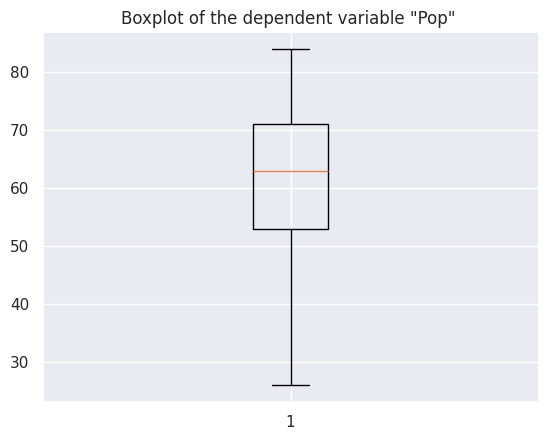

In [222]:
# Visualise the summary statistics.

sns.set(font_scale=1)
plt.title("""Boxplot of the dependent variable "Pop" """)
plt.boxplot(data_train["pop"])

((array([16., 17., 30., 33., 30., 67., 76., 86., 74., 24.]),
  array([26. , 31.8, 37.6, 43.4, 49.2, 55. , 60.8, 66.6, 72.4, 78.2, 84. ]),
  <BarContainer object of 10 artists>),
 -0.650195259825975)

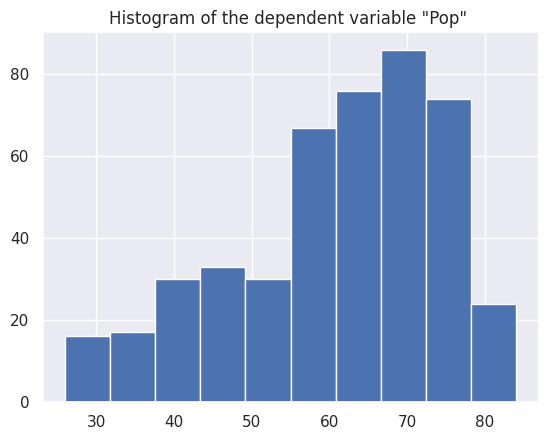

In [223]:
# Plot its distribution.

sns.set(font_scale=1)
plt.title("""Histogram of the dependent variable "Pop" """)
plt.hist(data_train["pop"]), data_train["pop"].skew()

## Explore the numeric features and their relation with the dependet variable

As an initial insight in “pop’s” dependence on numeric independent variables, we had calculated their correlation coefficients. Looking at absolute values in the table, we note “pop” has the strongest correlation with acoustic (“acous”) variable of -0.47 followed by duration (“dur”) variable of 0.36. These are not strong correlations and could indicate very low dependency of “pop” on our numeric variables. In further support of this, most other variables have very weak (below 0.2) absolute correlations with “pop”. The relationships between numeric variables were also visualised by creating pairwise scatterplots. The figure does not show any clear individual dependency of “pop” on other numeric variables apart from positive relation with song duration and negative relation with acoustic variable. Looking at other pairplots, the most noticeable relationships are those between energy and dB variables and that of energy with acoustic variable. High correlation between energy and dB indicates that including both variables into our models may be redundant. Due to high noise present in our scatterplots, we have not considered any transformations of our features.

In [224]:
# Find the summary statistics of numeric variables.

data_train.drop(columns = ["Id","year","pop"]).describe()

,bpm,nrgy,dnce,dB,live,val,dur,acous,spch
count,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000
mean,118.399558,60.070640,59.565121,-8.836645,17.757174,59.465784,226.278146,32.982340,5.660044
std,25.238713,22.205284,15.484458,3.577187,13.830300,24.539868,63.770380,29.530015,5.550581
min,62.000000,7.000000,18.000000,-24.000000,2.000000,6.000000,98.000000,0.000000,2.000000
25%,100.000000,43.000000,49.000000,-11.000000,9.000000,42.000000,181.000000,7.000000,3.000000
50%,119.000000,63.000000,61.000000,-8.000000,13.000000,61.000000,223.000000,24.000000,4.000000
75%,133.000000,78.000000,70.000000,-6.000000,23.000000,80.000000,262.000000,58.000000,6.000000
max,199.000000,100.000000,96.000000,-1.000000,93.000000,99.000000,511.000000,100.000000,47.000000


<Axes: >

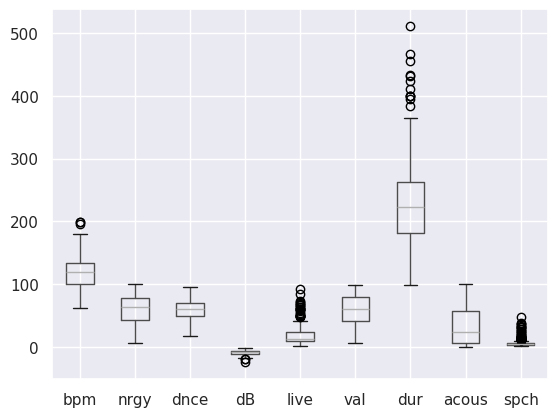

In [225]:
# Visualise the summary statistics.

sns.set(font_scale=1)
data_train.loc[:, ["bpm", "nrgy", "dnce", "dB", "live", "val", "dur", "acous", "spch"]].boxplot()

# Variables "live", "dur" and "spch" contain a high number of large outliers.

<Axes: >

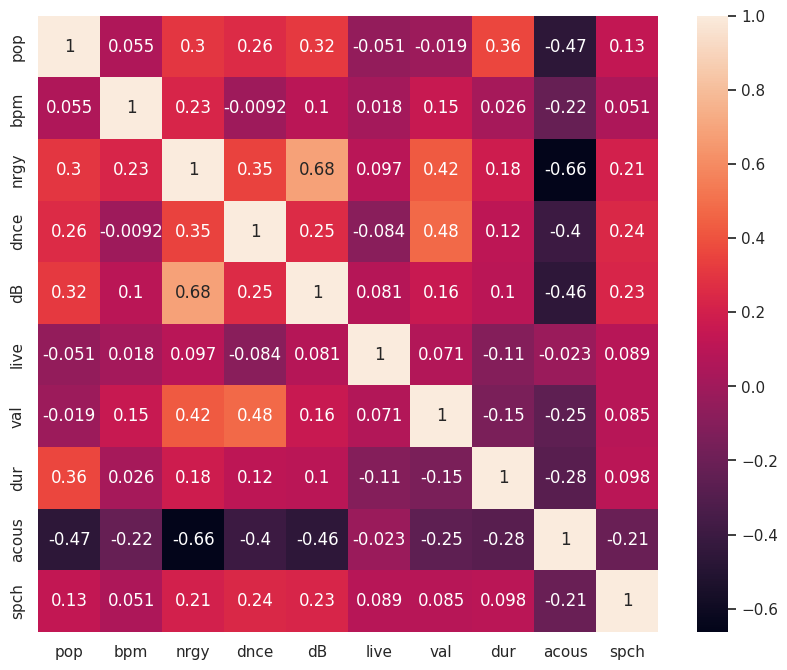

In [226]:
# Eplore the correlation between numeric variables.

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10, 8)) # For adjusting the figure size
sns.heatmap(data_train.loc[:,["pop", "bpm", "nrgy", "dnce", "dB", "live", "val", "dur", "acous", "spch"]].corr(), annot = True)

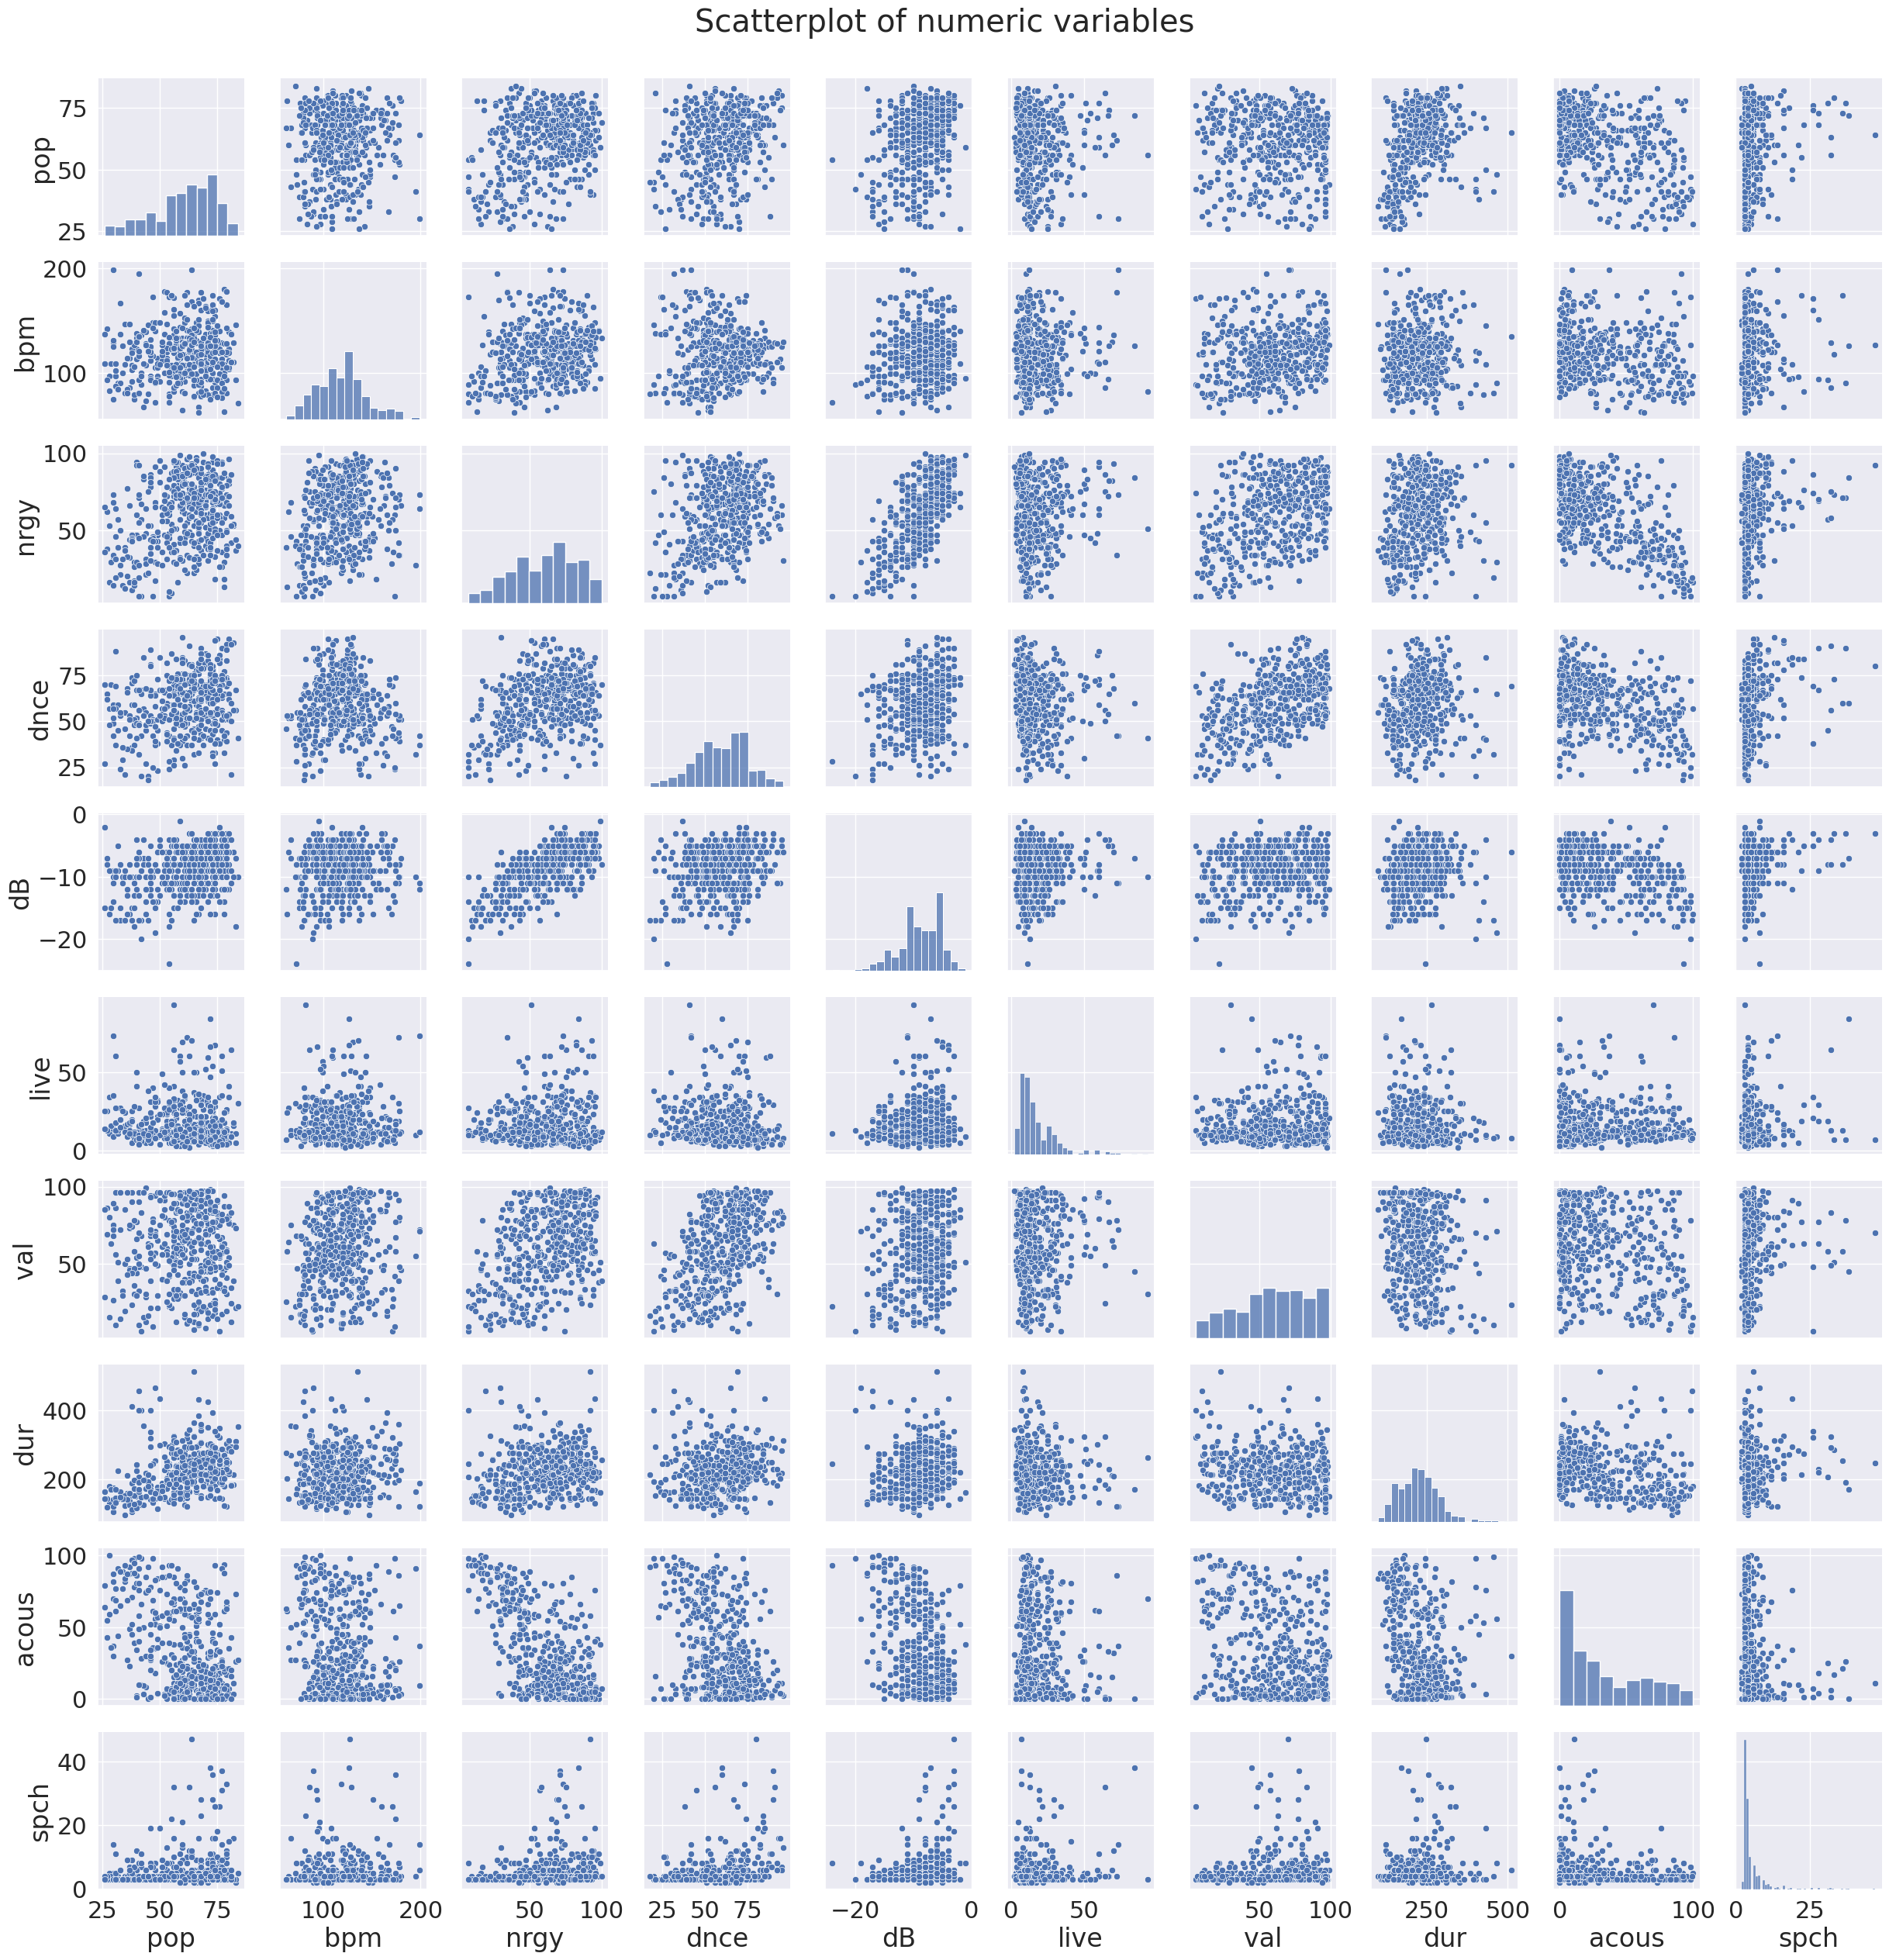

In [227]:
# Pairwise plot the numeric variables using Scatterplot.

sns.set(font_scale=2)
sns.pairplot(data_train.loc[:, ["pop", "bpm", "nrgy", "dnce", "dB", "live", "val", "dur", "acous", "spch"]]).fig.suptitle("Scatterplot of numeric variables", y=1.02)
plt.show()

## Explore "Top genre" feature and its relation with the dependent variable

The only categorical feature in our data is “top genre”. It contains 86 different categories, most of which (60) appear two or less times. Further, this is the only feature in our data containing missing values, 15 in total. We labelled these as “Other” and thus ended with 87 different genre values. Such high number of categories in respect to data size should not add much to our prediction models. Therefore, we considered using one-hot encoding with three most frequent categories and remaining observations labelled as “Other”. The summary statistics of “pop” grouped by our transformed “top genre” feature is shown and visualised in this section. Categories “Other”, “Album rock” and “Dance pop” had similar values with the only major difference being larger distribution of values in “Other” category. Values in “Adult standard” appeared to be the most different form the rest. However, these values account for only small portion of the total data are only likely to give us marginal improvement in our predictions. Therefore, we have excluded “top genre” feature from our initial prediction models.

In [228]:
# Return the number of unique genres.

data_train["top genre"].nunique()

87

In [229]:
# Count the number of appearence of each genre.

data_train["top genre"].value_counts()

,count
top genre,
adult standards,68
album rock,66
dance pop,61
brill building pop,16
glam rock,16
...,...
blues,1
bow pop,1
australian rock,1


In [230]:
# Count the number of genres that appear two times or less.

(data_train["top genre"].value_counts() <= 2).sum()

60

In [231]:
# Explore if the summary statistics for "pop" changes for different music genres (use only the first few most common genres).
# If it does, there is a potential to include one-hot encoding.

data_train_onehot = data_train.copy()
data_train_onehot.loc[(data_train_onehot['top genre'] != 'adult standards') & (data_train_onehot['top genre'] != 'album rock') & (data_train_onehot['top genre'] != 'dance pop'), 'top genre'] = 'Other'

In [232]:
# Display the sumamry statistics of "Pop" grouped by the most popular genres.

data_train_onehot.groupby("top genre")["pop"].describe()

,count,mean,std,min,25%,50%,75%,max
top genre,,,,,,,,
Other,258.0,59.620155,14.694129,26.0,51.00,62.5,71.0,84.0
adult standards,68.0,55.073529,11.747742,35.0,45.75,54.5,63.0,78.0
album rock,66.0,65.363636,9.858439,40.0,58.25,67.0,73.0,83.0
dance pop,61.0,66.819672,8.930301,40.0,61.00,69.0,74.0,80.0


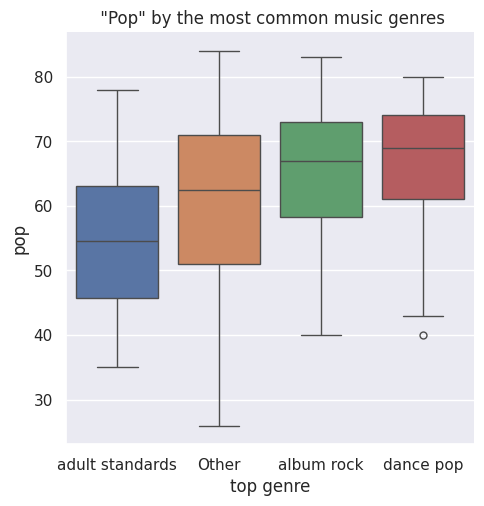

In [233]:
# Plot the summary statistics for four different 'top categories'.

sns.set(font_scale=1)
sns.catplot(kind='box', data=data_train_onehot, x='top genre', y='pop', hue='top genre').set(title = """ "Pop" by the most common music genres""")

## Dimension reduction with PCA

To better visualise the dependence of our data on our independent variables, we will perform PCA to reduce the dimension of our data set.

In [234]:
pca_3 = PCA(n_components=3) # Adjust the n_components parameter and note the change in the explained variance
data_train_pca_3 = pca_3.fit_transform(data_train.loc[:, ["bpm", "nrgy", "dnce", "dB", "live", "val", "dur", "acous", "spch"]],data_train['pop'])
print(pca_3.explained_variance_ratio_)
print(pca_3.singular_values_)

[0.58778383 0.18828877 0.08144303]
[1377.83617708  779.83186774  512.87995477]


Reducing the dimension to 2-d space explains 77.61% of variance. By adding third dimension, this is further increased to 85.71% of variance.

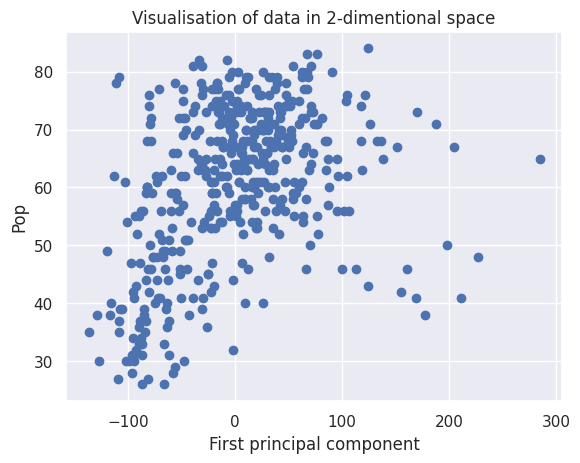

In [235]:
# In order to plot our data in two dimensional space, use PCA with n_components = 1.

pca_1 = PCA(n_components=1)
data_train_pca_1 = pca_1.fit_transform(data_train.loc[:, ["bpm", "nrgy", "dnce", "dB", "live", "val", "dur", "acous", "spch"]],data_train['pop'])
plt.title("Visualisation of data in 2-dimentional space")
plt.xlabel("First principal component")
plt.ylabel("Pop")
plt.plot(data_train_pca_1, data_train['pop'], "o")

From this figure it is clear that more than one dimension of the data will be required to build a prediction model.

# Building prediction models

Our analysis will use four different prediction models: OLS regression, Decision Tree (DT), Random Forest (RF) and Gaussian Process Regression (GPR). These models have different underlying assumptions, working principles and prediction capabilities.

To trainin them we will use three different versions of the training data. First, all models will be built using all numeric features. This will be followed by building models on truncated training set which excludes features of low correlation with ”pop” variable. Lastly, we will reduce the dimension of the training data using Principal Component Analysis and again trained all the models.

In each approach, our trainig set is first divided into a new smaller training set and a validation set. Models are built on the smaller training set and evaluated on the validation set. Guided by their performance on the validation test, we will change their hyperparameters. Once we think the optimal model was obtained, the whole training data will be used to retrain the model. The retrained models will then be used to make predictions on test data which will be submitted as our Kaggle challenge submissions.

In [236]:
# Split the trainig data into dependent and independent variables.

ex = ["Id", "year","pop","title","artist","top genre"]
X_train_full = data_train.loc[:,data_train.columns.difference(ex)]
y_train_full = data_train['pop']

 These variables will not be changed throughout the entire code. Instead, where altered version is required, we will create a copy of them to be modified.

In [237]:
# Further split the data into training and validation set using 80/20 ratio.

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state = 49)

## Linear Regression

We excpect this model to perform poorly do to lack of linearity between the variables which was noted in Scatterplots. However, due its simplicy we have still decided to consider it.

### Build models

In [238]:
# Create a copy of X_train and add a column of ones to it.
# This is required for calculating the offset using OLS function from statsmodels.api.

X_train_ones = X_train.copy()
intercept = np.ones(len(X_train_ones))
X_train_ones["Intercept"] = intercept  # Add the column of ones to calculate the intercept

OLS_1 = OLS(y_train,X_train_ones).fit() # Fit the model

OLS_1.summary() # Display variables coefficients and p-values

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pop   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     17.50
Date:                Tue, 25 Feb 2025   Prob (F-statistic):           6.12e-24
Time:                        11:13:12   Log-Likelihood:                -1392.9
No. Observations:                 362   AIC:                             2806.
Df Residuals:                     352   BIC:                             2845.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
acous         -0.1474      0.029     -5.086      0.000      -0.204      -0.090
bpm           -0.0037      0.025     -0.146      0.884      -0.053       0.046
dB             0.5765      0.242      2.384      0.018       0.101       1.052
dnce           0.1247      0.049      2.571      0.011       0.029       0.220
dur            0.0446      0.011      4.134      0.000       0.023       0.066
live          -0.0425      0.046     -0.934      0.351      -0.132       0.047
nrgy          -0.0020      0.051     -0.039      0.969      -0.102       0.098
spch          -0.0603      0.127     -0.474      0.636      -0.310       0.190
val           -0.0934      0.032     -2.880      0.004      -0.157      -0.030
Intercept     60.9006      6.640      9.172      0.000      47.841      73.960
==============================================================================
Omnibus:                        3.439   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                3.477
Skew:                          -0.236   Prob(JB):                        0.176
Kurtosis:                       2.911   Cond. No.                     3.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Variables "bpm", "live", "energy" and "spch" are highly not significant.
These variables also had low correlation with "pop" in correlation matrix.
We will proceed by build another model without these variables, and compare the two models performance out-of-sample (on validation set).

In [239]:
# Build another linear regression model that excludes highly non-significant variables: "bpm", "live", "energy" and "spch".

X_train_ones_truncated = X_train.loc[:,X_train.columns.difference(["bpm", "live", "nrgy", "spch"])].copy()
intercept = np.ones(len(X_train_ones_truncated))
X_train_ones_truncated["Intercept"] = intercept  # Add the column of ones to calculate the intercept
OLS_2 = OLS(y_train,X_train_ones_truncated).fit()

OLS_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pop   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     31.51
Date:                Tue, 25 Feb 2025   Prob (F-statistic):           1.47e-26
Time:                        11:13:12   Log-Likelihood:                -1393.5
No. Observations:                 362   AIC:                             2799.
Df Residuals:                     356   BIC:                             2822.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
acous         -0.1452      0.025     -5.849      0.000      -0.194      -0.096
dB             0.5393      0.185      2.917      0.004       0.176       0.903
dnce           0.1290      0.046      2.794      0.005       0.038       0.220
dur            0.0447      0.010      4.274      0.000       0.024       0.065
val           -0.0980      0.029     -3.408      0.001      -0.155      -0.041
Intercept     58.8365      4.202     14.002      0.000      50.572      67.101
==============================================================================
Omnibus:                        3.342   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.188   Jarque-Bera (JB):                3.400
Skew:                          -0.231   Prob(JB):                        0.183
Kurtosis:                       2.890   Cond. No.                     1.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Test on validation set

In [240]:
# Run the first models on the validation set and calculate its RMSE.

X_val_ones = X_val.copy()
intercept = np.ones(len(X_val_ones))
X_val_ones["Intercept"] = intercept
root_mean_squared_error(y_val, OLS_1.predict(X_val_ones))

10.367887699541532

In [241]:
# Run the second models on the validation set and calculate its RMSE.

X_val_ones_truncated = X_val.loc[:,X_val.columns.difference(["bpm", "live", "nrgy", "spch"])].copy()
intercept = np.ones(len(X_val_ones_truncated))
X_val_ones_truncated["Intercept"] = intercept
root_mean_squared_error(y_val, OLS_2.predict(X_val_ones_truncated))

# 2nd model performs slightly better on the validation set compared to the first model.

10.297886470618154

### Rebuild the model with the full trainig data

In [242]:
# Rebuild the first model on the full training data and summarise it.

X_train_full_ones = X_train_full.copy()    # copy of the full training data
intercept = np.ones(len(X_train_full_ones))
X_train_full_ones["Intercept"] = intercept  # Add the column of ones to calculate the intercept
OLS_1_full = OLS(y_train_full,X_train_full_ones).fit()

OLS_1_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pop   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     22.81
Date:                Tue, 25 Feb 2025   Prob (F-statistic):           6.23e-32
Time:                        11:13:12   Log-Likelihood:                -1734.0
No. Observations:                 453   AIC:                             3488.
Df Residuals:                     443   BIC:                             3529.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
acous         -0.1637      0.026     -6.401      0.000      -0.214      -0.113
bpm           -0.0043      0.022     -0.195      0.846      -0.048       0.039
dB             0.6598      0.211      3.129      0.002       0.245       1.074
dnce           0.1199      0.043      2.766      0.006       0.035       0.205
dur            0.0467      0.009      5.139      0.000       0.029       0.065
live          -0.0204      0.039     -0.518      0.605      -0.098       0.057
nrgy          -0.0479      0.043     -1.116      0.265      -0.132       0.036
spch          -0.0225      0.101     -0.223      0.824      -0.221       0.176
val           -0.0738      0.028     -2.617      0.009      -0.129      -0.018
Intercept     62.5239      5.831     10.723      0.000      51.064      73.983
==============================================================================
Omnibus:                        3.124   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.210   Jarque-Bera (JB):                3.192
Skew:                          -0.198   Prob(JB):                        0.203
Kurtosis:                       2.888   Cond. No.                     3.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [243]:
# Use the model to predict values of test data and save them to a file

X_test_ones = data_test.loc[:,data_test.columns.difference(["Id", "artist", "title", "year", "top genre"])].copy() # Create a copy of test data
intercept = np.ones(len(X_test_ones))
X_test_ones["Intercept"] = intercept  # Add the column of ones to calculate the intercept

OLS_1_full = OLS(y_train_full,X_train_full_ones).fit()
OLS_predictions_1 = pd.DataFrame(OLS_1_full.predict(X_test_ones),columns = ["pop"])
OLS_predictions_1.insert(loc=0, column='Id', value = data_test["Id"])

results_1_1 = OLS_predictions_1 # Save the result for ensamble learning

OLS_predictions_1.to_csv("ols_predicitions_1.csv",index=False) # Save the predictions to a file

# OLS_predictions_1 # Uncomment to display the results

In [244]:
# Rebuild the second model using the full training data without the non-significant features

X_train_full_ones_truncated = X_train_full.loc[:, X_train_full.columns.difference(["bpm", "live", "nrgy", "spch"])].copy()    # Copy of the full training data
intercept = np.ones(len(X_train_full_ones_truncated))
X_train_full_ones_truncated["Intercept"] = intercept  # Add the column of ones to calculate the intercept

OLS_2_full = OLS(y_train_full,X_train_full_ones_truncated).fit()
OLS_2_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pop   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     40.92
Date:                Tue, 25 Feb 2025   Prob (F-statistic):           1.19e-34
Time:                        11:13:12   Log-Likelihood:                -1734.9
No. Observations:                 453   AIC:                             3482.
Df Residuals:                     447   BIC:                             3507.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
acous         -0.1486      0.022     -6.698      0.000      -0.192      -0.105
dB             0.5052      0.167      3.031      0.003       0.178       0.833
dnce           0.1278      0.041      3.089      0.002       0.046       0.209
dur            0.0458      0.009      5.116      0.000       0.028       0.063
val           -0.0885      0.025     -3.483      0.001      -0.138      -0.039
Intercept     57.4056      3.756     15.285      0.000      50.025      64.786
==============================================================================
Omnibus:                        2.792   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.248   Jarque-Bera (JB):                2.856
Skew:                          -0.187   Prob(JB):                        0.240
Kurtosis:                       2.892   Cond. No.                     1.79e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [245]:
# Run the model on the test data

X_test_ones_truncated = data_test.loc[:,data_test.columns.difference(["Id", "artist", "title", "year", "top genre","bpm", "live", "nrgy", "spch"])].copy() # create a copy of test data
intercept = np.ones(len(X_test_ones_truncated))
X_test_ones_truncated["Intercept"] = intercept  # Add the column of ones to calculate the intercept

OLS_predictions_2 = pd.DataFrame(OLS_2_full.predict(X_test_ones_truncated),columns = ["pop"])
OLS_predictions_2.insert(loc=0, column='Id', value = data_test["Id"])

results_1_2 = OLS_predictions_2 # Save the result for ensamble learning

OLS_predictions_2.to_csv("ols_predicitions_2.csv",index=False) # Save the predictions to a file

# OLS_predictions_2 # Uncomment to display the results

The full model achieved the score of 8.7822 on the test data, while the truncated model achieved slightly better score of 8.7683.

## Decision Tree


DT is another algorithm we choosen primarly for its simplicity. We do not excpet this model to perform well due to how noisy our data is. Despite this, we believe this model is a good benchmark for RF model which we will build in the next section.

### Build models

In [246]:
# Build the model using all features.

dec_tree_1 = DecisionTreeRegressor(min_samples_leaf = 20, random_state=49)   # Adjust the depth of the model to obtain better performance
dec_tree_1.fit(X_train, y_train)

DecisionTreeRegressor(min_samples_leaf=20, random_state=49)

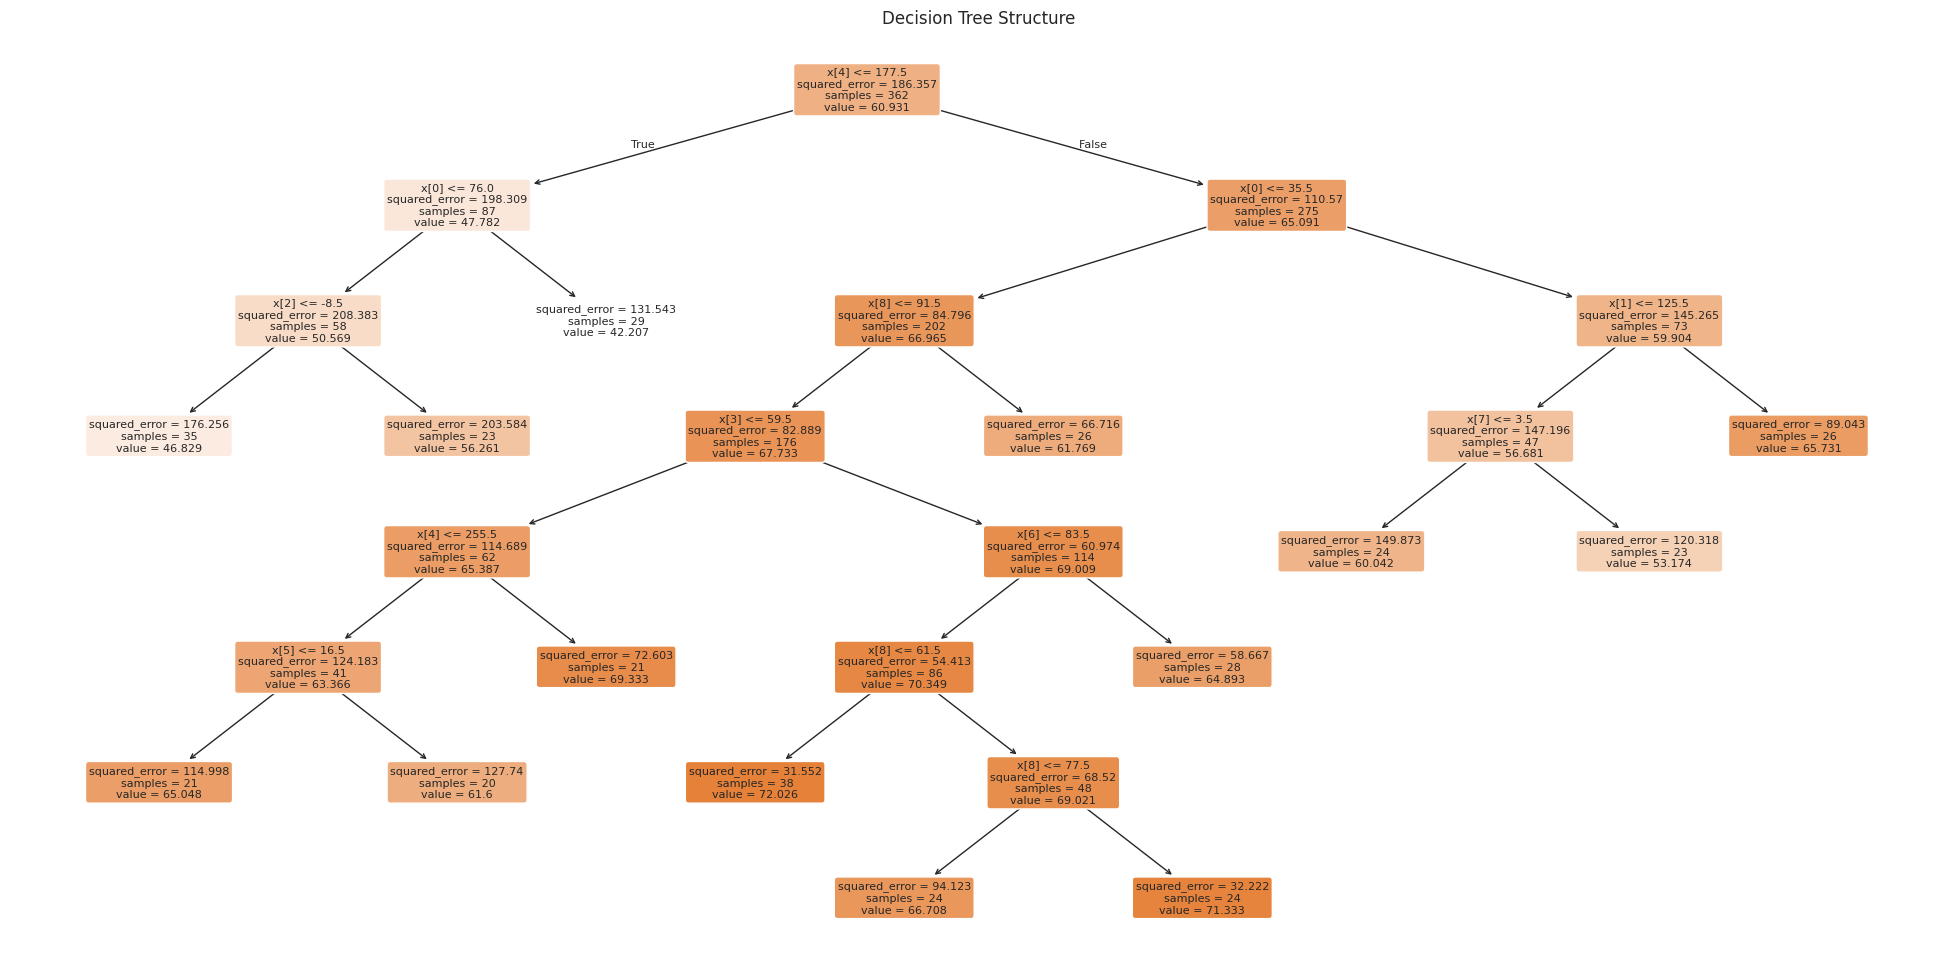

In [247]:
# Display the model.

plt.figure(figsize=(25, 12))
plot_tree(
    dec_tree_1,
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree Structure")
plt.show()

In [248]:
# Build a model without "bpm", "live", "nrgy" and "spch".

X_train_truncated = X_train.loc[:,X_train.columns.difference(["bpm", "live", "nrgy", "spch"])].copy()

dec_tree_2 = DecisionTreeRegressor(min_samples_leaf = 20, random_state=49)   # Later adjust the depth of the model
dec_tree_2.fit(X_train_truncated, y_train)

DecisionTreeRegressor(min_samples_leaf=20, random_state=49)

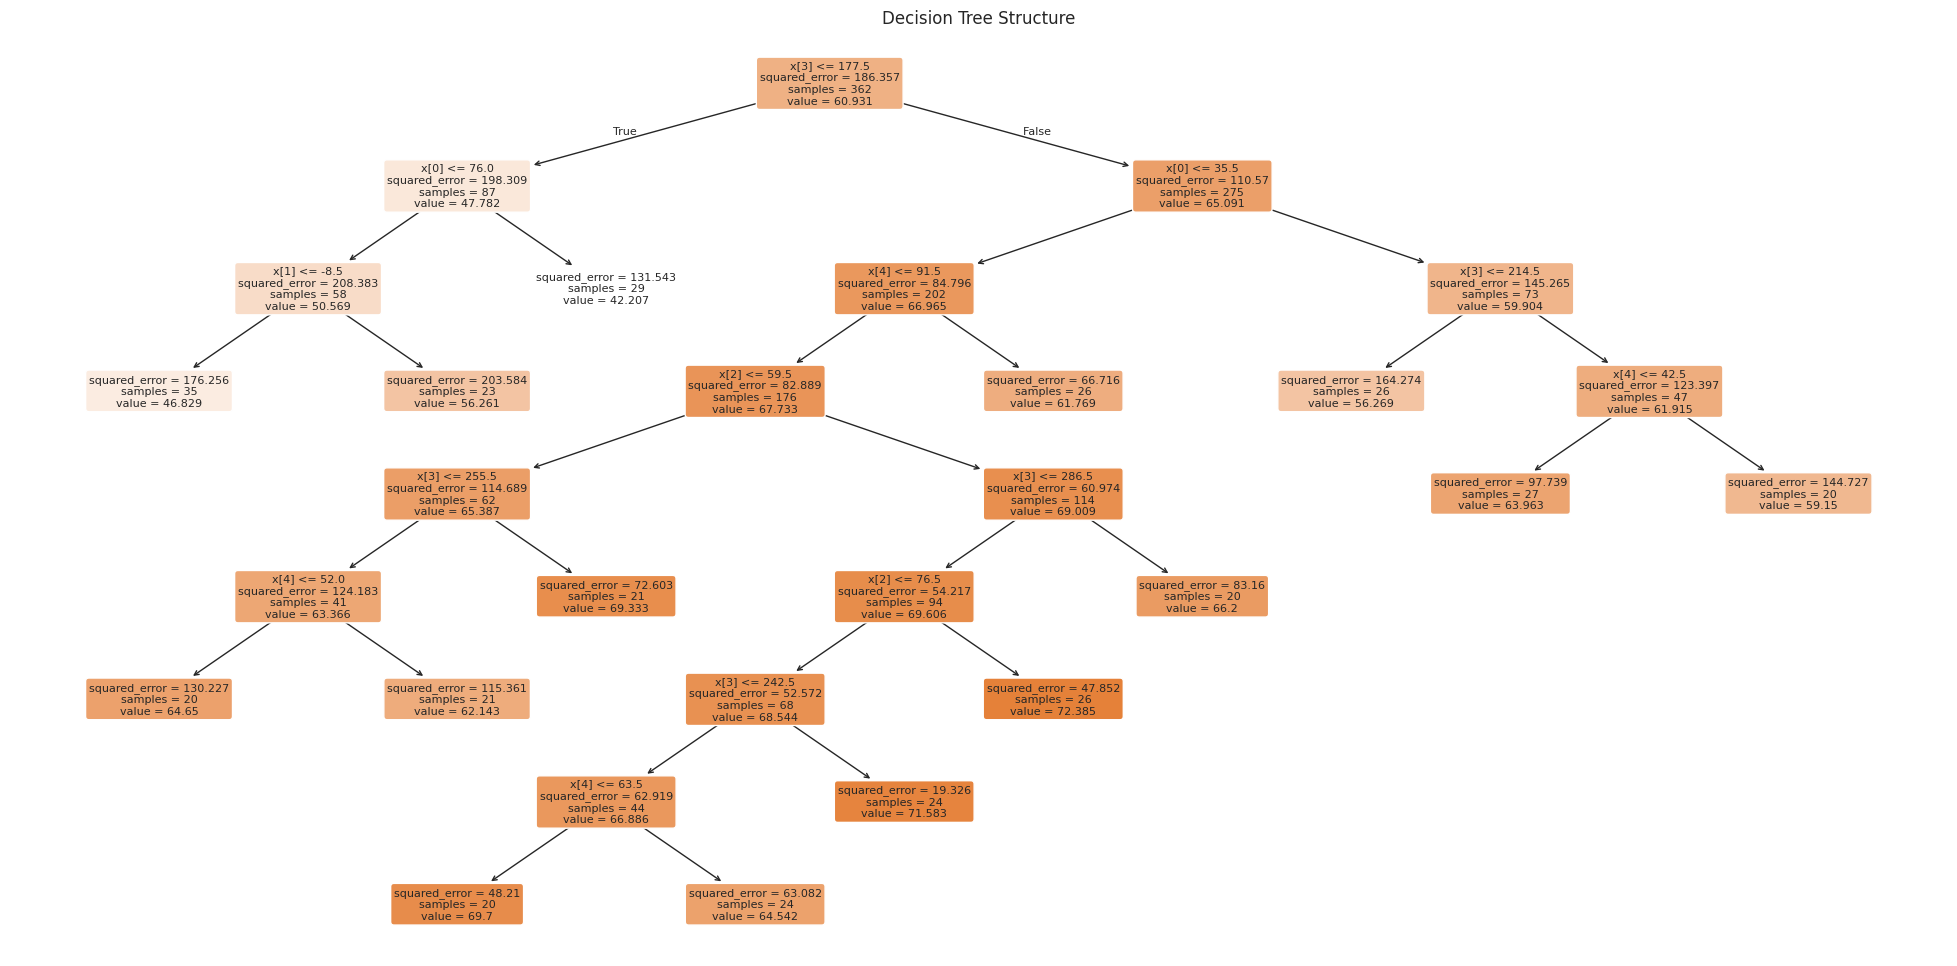

In [249]:
# Display the model.

plt.figure(figsize=(25, 12))
plot_tree(
    dec_tree_2,
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree Structure")
plt.show()

The two trees are almost indentical. This indicates that features we excluded were likely unused in the initial model (containing all the features).

### Test on validation set

In [250]:
# Explore the performance of the first model on the validation set.

root_mean_squared_error(y_val, dec_tree_1.predict(X_val))

10.140034689110177

In [251]:
# Explore the performance of the second model on the validation set.

ex = ["nrgy","bpm","live","spch"]   # Feature to be excluded
X_val_truncated = X_val.loc[:,X_val.columns.difference(ex)].copy()

root_mean_squared_error(y_val, dec_tree_2.predict(X_val_truncated))

10.474029340315298

The full DT model performed better than OLS regression on validation set. However, the truncated DT model produced worse result.

### Rebuild the models with the full training data

In [252]:
# Rebuild the first model using the whole training data set.

dec_tree_1_full = DecisionTreeRegressor(min_samples_leaf = 20, random_state=49)   # Later play with the depth of the model
dec_tree_1_full.fit(X_train_full, y_train_full)

DecisionTreeRegressor(min_samples_leaf=20, random_state=49)

In [253]:
# Make predictions and save them.

X_test = data_test.loc[:,data_test.columns.difference(["Id", "artist", "title", "year", "top genre"])].copy()
DT_predictions_1 = pd.DataFrame(dec_tree_1_full.predict(X_test), columns = ["pop"])
DT_predictions_1.insert(loc=0, column='Id', value = data_test["Id"])

results_2_1 = DT_predictions_1 # Store the result for ensemble learning

DT_predictions_1.to_csv("dt_predicitions_1.csv",index=False) # Create a file with predictions

# DT_predictions_1 # Uncomment to display the results

In [254]:
## Second model with all observations in training data and features "bpm", "live", "nrgy", "spch" excluded.

X_train_full_truncated = X_train_full.loc[:,X_train_full.columns.difference(["bpm", "live", "nrgy", "spch"])].copy()

dec_tree_2_full = DecisionTreeRegressor(min_samples_leaf = 20, random_state=49)   # Later play with the depth of the model
dec_tree_2_full.fit(X_train_full_truncated, y_train_full)

DecisionTreeRegressor(min_samples_leaf=20, random_state=49)

In [255]:
# Make predictions and save them.

X_test_truncated = data_test.loc[:,data_test.columns.difference(["Id", "artist", "title", "year", "top genre", "bpm", "live", "nrgy", "spch"])].copy()

DT_predictions_2 = pd.DataFrame(dec_tree_2_full.predict(X_test_truncated), columns = ["pop"])
DT_predictions_2.insert(loc=0, column='Id', value = data_test["Id"])

results_2_2 = DT_predictions_2 # Store the result for ensemble learning

DT_predictions_2.to_csv("dt_predicitions_2.csv",index=False) # Create a file with predictions

# DT_predictions_2 # Uncomment to display the results

Both DT models performed significantly worse on test data compared to OLS regression. The full model scored 9.3941, while the truncated model scored 9.5731.

## Random Forest

### Build models

Random Forest creates multiple DTs using different subsets of the training data and feature set. The predcitions of these models are then averaged to produce the final prediction. It is an ensemble learning approach which should mitigate the overfitting which often occurs in DT models.

In [256]:
# Model with all variables.

rand_for_1 = RandomForestRegressor(n_estimators= 60, random_state=49, criterion = "squared_error", min_samples_leaf = 10)
rand_for_1.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=10, n_estimators=60, random_state=49)

In [257]:
# Model without the variables of low correlation.

X_train_truncated = X_train.loc[:, X_train.columns.difference(["bpm", "live", "nrgy", "spch"])].copy()

rand_for_2 = RandomForestRegressor(n_estimators=50, random_state=49, criterion = "squared_error", min_samples_leaf = 10)
rand_for_2.fit(X_train_truncated, y_train)

RandomForestRegressor(min_samples_leaf=10, n_estimators=50, random_state=49)

### Test on validation set

In [258]:
# Predict on the validation data and change the hyperparameters.

root_mean_squared_error(y_val, rand_for_1.predict(X_val))

9.742116360480969

This is a noticable improvement over the two previosuly used models on the validation set.

In [259]:
# Evaluate the model on the validation set.
# Predict on the validation data and change the hyperparameters.


ex = ["nrgy","bpm","live","spch"]
X_val_truncated = X_val.loc[:,X_val.columns.difference(ex)].copy()

root_mean_squared_error(y_val, rand_for_2.predict(X_val_truncated))

10.068830047846495

The truncated model did not perform as well as the full model on the validation set. However, it still outperformed OLS regression and DT model.

### Rebuild models with the full training data

In [260]:
# Rebuild the first model with the full training data.

rand_for_1_full = RandomForestRegressor(n_estimators= 50, random_state=49, criterion = "squared_error", min_samples_leaf = 10)
rand_for_1_full.fit(X_train_full, y_train_full)

RandomForestRegressor(min_samples_leaf=10, n_estimators=50, random_state=49)

In [261]:
# Make predictions on the test data and save them to a file.

X_test = data_test.loc[:,data_test.columns.difference(["Id", "artist", "title", "year", "top genre"])].copy()
RF_predictions_1 = pd.DataFrame(rand_for_1_full.predict(X_test),columns = ["pop"])
RF_predictions_1.insert(loc=0, column='Id', value = data_test["Id"])

results_3_1 = RF_predictions_1 # Save the predictions for ensemble learning

RF_predictions_1.to_csv("rf_predicitions_1.csv",index=False) # Save predictions to a file

# RF_predictions_1 # Uncomment to display the results

In [262]:
# Rebuild the second model with the full training data.

ex = ["nrgy","bpm","live","spch"]  # Features to exclude
X_train_full_truncated = X_train_full.loc[:,X_train_full.columns.difference(ex)].copy()

rand_for_2_full = RandomForestRegressor(n_estimators= 50, random_state=49, criterion = "squared_error", min_samples_leaf = 10)
rand_for_2_full.fit(X_train_full_truncated, y_train_full)

RandomForestRegressor(min_samples_leaf=10, n_estimators=50, random_state=49)

In [263]:
# Make predictions and save them to a file.

X_test_truncated = data_test.loc[:,data_test.columns.difference(["Id", "artist", "title", "year", "top genre", "bpm", "live", "nrgy", "spch"])].copy()

RF_predictions_2 = pd.DataFrame(rand_for_2_full.predict(X_test_truncated), columns = ["pop"])
RF_predictions_2.insert(loc=0, column='Id', value = data_test["Id"])

results_3_2 = RF_predictions_2 # Save the predictions for ensemble learning

RF_predictions_2.to_csv("rf_predicitions_2.csv",index=False) # Save predictions to a file

# RF_predictions_2 # Uncomment to display the results

Both RF models produced better results on test data than all previous models. Further, their performance was almost identical. Full model scored 8.4423, while truncated model scored 8.4482.

## Gaussian Process Regression

Gaussian Process Regression is the most complext model that we will use in this project. It can model complex relationships in data and we will apply it using some of the most popular kernels.

### Build models

In [264]:
# Define few kernals whose parameters will be changed based on models performance on validation data.

kernel_1 = 2.0 * kernels.RBF(length_scale=1.5)
kernel_2 = kernels.RationalQuadratic()
kernel_3 = kernels.Matern(nu = 5.5)

In [265]:
# Define the first model and change the kernals based on its performance on validation data.

gp_1 = GaussianProcessRegressor(kernel = kernel_3, alpha=0.5, normalize_y=True, n_restarts_optimizer=20)

In [266]:
# Fit the model using full feature set.

gp_1.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.5, kernel=Matern(length_scale=1, nu=5.5),
                         n_restarts_optimizer=20, normalize_y=True)

Repeat the process without "nrgy","bpm","live","spch".

In [267]:
# Define few kernals.

kernel_1_ = 2.0 * kernels.RBF(length_scale=1.5)
kernel_2_ = kernels.RationalQuadratic()
kernel_3_ = kernels.Matern(nu = 1.5)

In [268]:
# Fit the model using truncated data.

ex = ["nrgy","bpm","live","spch"] # Features to exclude
X_train_truncated = X_train.loc[:,X_train.columns.difference(ex)].copy()

gp_2 = GaussianProcessRegressor(kernel = kernel_1_, alpha=0.5, normalize_y=True, n_restarts_optimizer=20) # Change the kernels and their parameters and note the change in the performance
gp_2.fit(X_train_truncated, y_train)

GaussianProcessRegressor(alpha=0.5, kernel=1.41**2 * RBF(length_scale=1.5),
                         n_restarts_optimizer=20, normalize_y=True)

### Test on validation set

In [269]:
# Evaluate the 1st models performance.

root_mean_squared_error(y_val, gp_1.predict(X_val))

9.649157585481726

In [270]:
# Evaluate the 2nd models performance.

ex = ["nrgy","bpm","live","spch"] # Features to exclude
X_val_truncated = X_val.loc[:,X_val.columns.difference(ex)]

root_mean_squared_error(y_val, gp_2.predict(X_val_truncated))

9.650986321156088

The two models performed almost identically and managed to outperform all the previous models. This was not the case just for our last choosen kernels, but for all the defined kernels.

### Rebuild the models  with the full training data

In [271]:
# Define and fit the first model.

gp_1_full = GaussianProcessRegressor(kernel = kernel_2, alpha=0.5, normalize_y=True, n_restarts_optimizer=30)
gp_1_full.fit(X_train_full, y_train_full)

GaussianProcessRegressor(alpha=0.5,
                         kernel=RationalQuadratic(alpha=1, length_scale=1),
                         n_restarts_optimizer=30, normalize_y=True)

In [272]:
# Make predictions on test data and save them to a file.

X_test = data_test.loc[:,data_test.columns.difference(["Id", "full", "year","title","artist","top genre"])].copy()

GP_predictions_1 = pd.DataFrame(gp_1_full.predict(X_test),columns = ["pop"])
GP_predictions_1.insert(loc=0, column='Id', value = data_test["Id"])

results_4_1 =  GP_predictions_1 # Save the predictions for later use in ensamble learninig

GP_predictions_1.to_csv("gp_predicitions_1.csv",index=False)  # Save prediction to a file

# GP_predictions_1 # Uncomment to display the results

In [273]:
# Define and fit the second model.

ex = ["nrgy","bpm","live","spch"] # Features to exclude
X_train_full_truncated = X_train_full.loc[:,X_train_full.columns.difference(ex)]

gp_2_full = GaussianProcessRegressor(kernel = kernel_3_, alpha=0.5, normalize_y=True, n_restarts_optimizer=30)
gp_2_full.fit(X_train_full_truncated, y_train_full)

GaussianProcessRegressor(alpha=0.5, kernel=Matern(length_scale=1, nu=1.5),
                         n_restarts_optimizer=30, normalize_y=True)

In [274]:
# Make predictions on test data and save them to a file.

X_test_truncated = data_test.loc[:,data_test.columns.difference(["Id", "artist", "title", "year", "top genre", "bpm", "live", "nrgy", "spch"])].copy()

GP_predictions_2 = pd.DataFrame(gp_2_full.predict(X_test_truncated),columns = ["pop"])
GP_predictions_2.insert(loc=0, column='Id', value = data_test["Id"])

results_4_2 = GP_predictions_2 # Save the predictions for ensemble learning

GP_predictions_2.to_csv("gp_predicitions_2.csv",index=False) # Save the predictions to a file

# GP_predictions_2 # Uncomment to display the results

GPR models were the clear winners on test data in our analysis, with the full model scoring 7.8999 and trancated model scoring 8.1360.

## Average the prediction results

We further averaged all our models in hopes of ensamble learning approach producing superior results.

In [275]:
# Average of models built using the full feature set.

avr_1 = (results_1_1 + results_2_1 + results_3_1 + results_4_1)/4

# avr_1 # Uncomment to display the results

In [276]:
# Average of models built using the truncated feature set.

avr_2 = (results_1_2 + results_2_2 + results_3_2 + results_4_2)/4

# avr_2 # Uncomment to display the results

In [277]:
# Averages all built models.

avr_3 = (results_1_1 + results_2_1 + results_3_1 + results_4_1+results_1_2 + results_2_2 + results_3_2 + results_4_2)/8

In [278]:
# Save these results.

AVR_predictions_1 = pd.DataFrame(avr_1,columns = ["pop"])
AVR_predictions_1.insert(loc=0, column='Id', value = data_test["Id"])
AVR_predictions_1.to_csv("avr_predicitions_1.csv",index=False)

AVR_predictions_2 = pd.DataFrame(avr_2,columns = ["pop"])
AVR_predictions_2.insert(loc=0, column='Id', value = data_test["Id"])
AVR_predictions_2.to_csv("avr_predicitions_2.csv",index=False)

AVR_predictions_3 = pd.DataFrame(avr_3,columns = ["pop"])
AVR_predictions_3.insert(loc=0, column='Id', value = data_test["Id"])
AVR_predictions_3.to_csv("avr_predicitions_3.csv",index=False)

All three averaged results scored slightly above 8, which was not superior to GPR models previosuly produced.

# Building models with data of reduced dimension (using PCA)

Lastly, we will build the models using data of reduced dimension.

In [279]:
# Try reducing the dimensions to: to 1, 2, 3 and 4 dimensions (by changing n_components value),
# and evaluate the models built with reduced data on validation set

pca_3 = PCA(n_components=3)
data_train_pca_3 = pca_3.fit_transform(data_train.loc[:, ["bpm", "nrgy", "dnce", "dB", "live", "val", "dur", "acous", "spch"]],data_train['pop'])
print(pca_3.explained_variance_ratio_)
print(pca_3.singular_values_)

[0.58778383 0.18828877 0.08144303]
[1377.83617708  779.83186774  512.87995477]


In [280]:
# Create training and validation data from PCA data set

X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(data_train_pca_3, y_train_full, test_size = 0.2, random_state = 49)

### Linear regression

In [281]:
# Fit the model

lin_reg_pca = LinearRegression().fit(X_train_pca, y_train_pca)
lin_reg_pca.coef_

array([ 0.08203314, -0.09724772, -0.0303762 ])

In [282]:
# Evaluate it.

root_mean_squared_error(y_val_pca, lin_reg_pca.predict(X_val_pca))

10.766452323093482

OLS model performed poorly on all four PCA models which were considered.

### Decision tree

In [283]:
# Fit the model.

dec_tree_pca = DecisionTreeRegressor(min_samples_leaf = 20, random_state=49)   # Later play with the depth of the model
dec_tree_pca.fit(X_train_pca, y_train_pca)

DecisionTreeRegressor(min_samples_leaf=20, random_state=49)

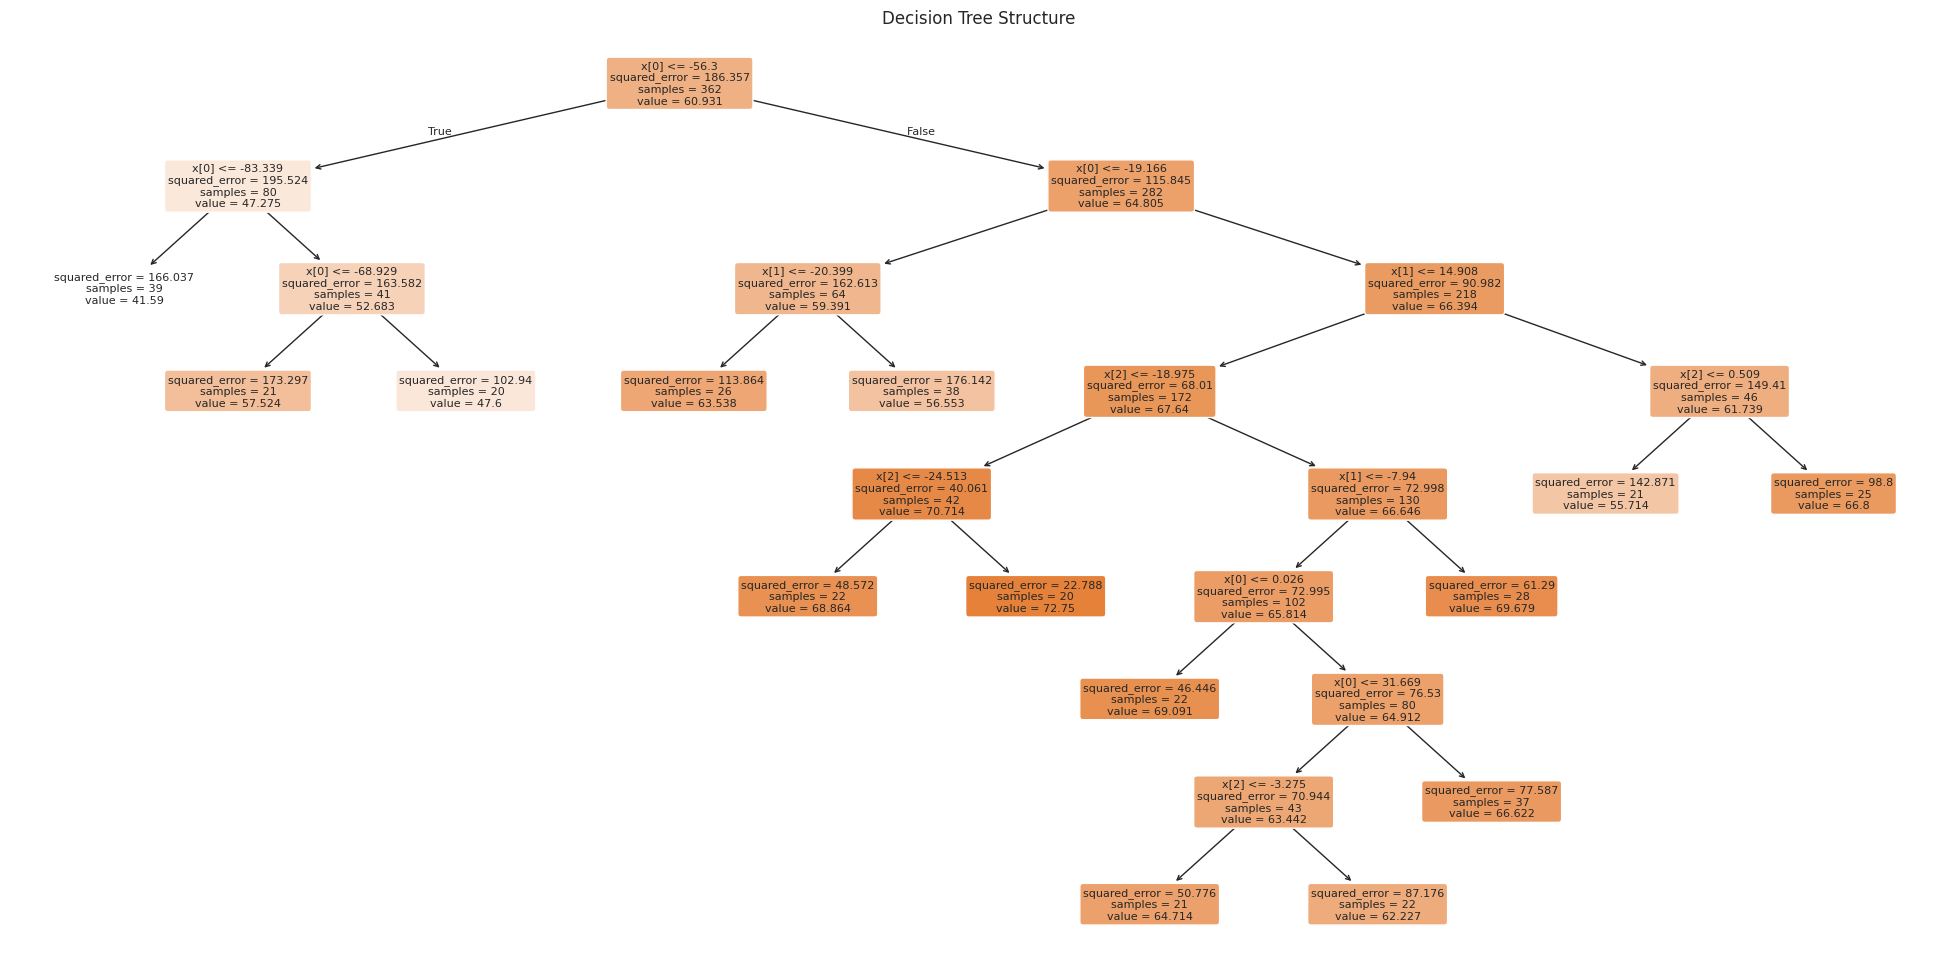

In [284]:
# Plot the model.

plt.figure(figsize=(25, 12))
plot_tree(
    dec_tree_pca,
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree Structure")
plt.show()

In [285]:
# Evaluate it.

root_mean_squared_error(y_val_pca, dec_tree_pca.predict(X_val_pca))

10.661721247125778

The performance of DT has also not improved with the reduction dimensionality.

### Random Forest

In [286]:
# Fit the model.

rand_for_1_pca = RandomForestRegressor(n_estimators= 20, random_state=49, criterion = "squared_error", min_samples_leaf = 20)
rand_for_1_pca.fit(X_train_pca, y_train_pca)

RandomForestRegressor(min_samples_leaf=20, n_estimators=20, random_state=49)

In [287]:
# Evaluate it.

root_mean_squared_error(y_val_pca, rand_for_1_pca.predict(X_val_pca))

9.965855668179382

RF achieved similar performance to its model built with non-reduced training data.

### Gaussian process regression

In [288]:
# Define kernels to use.

kernel_pca_1 = 2*kernels.RBF(length_scale= 0.5)
kernel_pca_2 = kernels.RationalQuadratic()
kernel_pca_3 = kernels.Matern(nu = 1.5)

In [289]:
# Fit the model and evaluate it.
# Use different kernels to optimise the models performance.

gp_1_pca = GaussianProcessRegressor(kernel = kernel_pca_3, alpha=0.5, normalize_y=True, n_restarts_optimizer=10)

gp_1_pca.fit(X_train_pca, y_train_pca)

root_mean_squared_error(y_val_pca, gp_1_pca.predict(X_val_pca))

9.669088070131176

GPR model performed well data reduced to 2, 3 and 4 dimensions.

## Retrain well performing models on the full training data

As RF and GPR performed well with lower dimenison data, we decided to retrain them using the whole training set (including the validation set) and evaluate on test data.

In [290]:
# Random Forest.
# Fit the model and make predictions on the test data.

X_test = data_test.loc[:,data_test.columns.difference(["Id", "artist", "title", "year", "top genre"])]
data_test_pca_3 = pca_3.fit_transform(X_test.loc[:, ["bpm", "nrgy", "dnce", "dB", "live", "val", "dur", "acous", "spch"]])
RF_predictions_1_pca = pd.DataFrame(rand_for_1_pca.predict(data_test_pca_3),columns = ["pop"])

RF_predictions_1_pca.insert(loc=0, column='Id', value = data_test["Id"])
# RF_predictions_1_pca # Uncomment to display the results

In [291]:
# Save them to a file.

RF_predictions_1_pca.to_csv("rf_predicitions_pca.csv",index=False)

The RF model achieved the score of 8.2704 on test data.

In [292]:
# Gaussian Process Regression.
# Fit the model.

gp_1_pca = GaussianProcessRegressor(kernel = kernel_pca_3, alpha=0.5, normalize_y=True, n_restarts_optimizer=20)
gp_1_pca.fit(data_train_pca_3, y_train_full)

GaussianProcessRegressor(alpha=0.5, kernel=Matern(length_scale=1, nu=1.5),
                         n_restarts_optimizer=20, normalize_y=True)

In [293]:
# Make and save the predictions.

X_test = data_test.loc[:,data_test.columns.difference(["Id", "artist", "title", "year"])]
data_test_pca_3 = pca_3.fit_transform(X_test.loc[:, ["bpm", "nrgy", "dnce", "dB", "live", "val", "dur", "acous", "spch"]])
GP_predictions_1_pca = pd.DataFrame(gp_1_pca.predict(data_test_pca_3),columns = ["pop"])

GP_predictions_1_pca.insert(loc=0, column='Id', value = data_test["Id"])
GP_predictions_1_pca.to_csv("gp_predicitions_3_pca.csv",index=False)
# GP_predictions_1_pca # Uncomment to display the results

GPR model has outperformed all our previous models on test data achieving the score of 7.8297.

# Conclusion

In this notebook we documented our entrance to CS985/6 Spotify Regression Problem 2025 Kaggle challenge. Four models of different natures and assumptions were built using different subsets of feature set. Among the selected models, the best performance on test data was achieved using GPR with data reduced to three dimensions using PCA.